In [1]:
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import emcee
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.time import Time

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper')

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
df = pd.read_csv('../data/preliminary_results.csv')

In [3]:
df

,date,ew,ew_unc,gaussian_width,gaussian_width_unc,int_wv,jd,obs_line_center,obs_line_center_unc,qidx,star_name,time
0,2020-07-16,1.395396,0.011383,1.106483,0.008653,8542.0,2.459047e+06,8542.580358,0.005900,6245.0,HAT-P-11,09:48:47
1,2020-07-16,1.393457,0.012172,1.104836,0.009116,8542.0,2.459047e+06,8542.569886,0.006126,6245.0,HAT-P-11,09:54:28
2,2020-07-24,1.363641,0.011335,1.021007,0.008478,8542.0,2.459055e+06,8542.621869,0.005607,7146.0,HAT-P-11,09:46:12
3,2020-07-24,1.353275,0.011725,1.016546,0.008920,8542.0,2.459055e+06,8542.621205,0.006006,7146.0,HAT-P-11,09:51:53
4,2020-08-01,1.350895,0.015188,1.007118,0.011331,8542.0,2.459063e+06,8542.646190,0.007561,7226.0,HAT-P-11,03:08:30
...,...,...,...,...,...,...,...,...,...,...,...,...
251,2020-07-23,1.295602,0.033399,1.162988,0.023019,8542.0,2.459054e+06,8543.554631,0.012569,7153.0,k2-141_p4,08:59:38
252,2020-07-23,1.248483,0.031135,1.136685,0.021815,8542.0,2.459054e+06,8543.546212,0.012685,7153.0,k2-141_p4,09:08:41
253,2020-03-11,-1.205224,0.063617,1.390071,0.041747,8542.0,2.458920e+06,8541.724556,0.052500,3201.0,k2-266_in,04:26:25
254,2020-03-11,-1.349358,0.077149,1.482480,0.044933,8542.0,2.458920e+06,8541.607933,0.055075,3201.0,k2-266_in,04:35:29


In [4]:
df.star_name.value_counts()

HAT-P-67b_IN_1                14
HAT-P-67b_IN_2                14
HAT-P-17b_IN_1b               11
HAT-P-17b_IN_3                10
HAT-P-67b_OUT_same3            9
HAT-P-67b_IN_3                 9
HAT-P-17b                      6
HAT-P-32_3_IN                  6
HAT-P-11                       6
HAT-P-32_1_IN                  6
HAT-P-17b_OUT_1b_before1       6
HD189733                       6
HAT-P-12_OUT_2                 5
HAT-P-12_IN_2                  5
HAT-P-12_OUT_1_before2         5
HAT-P-12_OUT_1                 5
HAT-P-17b_OUT_3_after2         4
HAT-P-67b_OUT_2_after2         4
HAT-P-67b_OUT_3_before1        4
HAT-P-67b_OUT_2_after1         4
HAT-P-32_2_OUT_b2              4
HAT-P-67b_OUT_3_after1         4
HAT-P-17b_OUT_3_same           4
HAT-P-17b_OUT_1_before1        4
Tres-1b_OUT_2b_before          4
HAT-P-67b_OUT_2_before2        4
HAT-P-67b_OUT_3_after2         4
HAT-P-17b_OUT_3_before2        4
hat-p-40_p4                    4
HAT-P-17b_OUT_1b_after2p1      4
HAT-P-12_O

We retrieved the data for the planets from [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/)

In [5]:
target_name = 'HAT-P-67'
orbital_period = 4.81010250
t_c = 2455961.38467
t_c_btjd = t_c-2457000.0 #neg value means discovered before TESS

In [6]:
target_mask = df.star_name.str.contains(target_name)
df = df[target_mask]
keep_mask = df.ew_unc < 10 #original value = 1

In [7]:
df

,date,ew,ew_unc,gaussian_width,gaussian_width_unc,int_wv,jd,obs_line_center,obs_line_center_unc,qidx,star_name,time
158,2020-04-28,16.742296,2.139550,7.450902,1.241280,8542.0,2.458968e+06,8534.344715,1.222483,6437.0,HAT-P-67b_IN_1,06:10:31
159,2020-04-28,15.685394,2.056800,6.858278,1.227192,8542.0,2.458968e+06,8534.980822,1.198727,6437.0,HAT-P-67b_IN_1,06:16:12
160,2020-04-28,-0.585157,0.116374,0.748590,0.126750,8542.0,2.458968e+06,8541.174578,0.100627,6437.0,HAT-P-67b_IN_1,06:21:53
161,2020-04-28,17.156088,2.333331,7.648749,1.368716,8542.0,2.458968e+06,8534.122726,1.345702,6437.0,HAT-P-67b_IN_1,06:27:34
162,2020-04-28,17.593328,2.110932,7.946033,1.163876,8542.0,2.458968e+06,8533.907138,1.145241,6437.0,HAT-P-67b_IN_1,06:33:15
...,...,...,...,...,...,...,...,...,...,...,...,...
238,2020-06-16,16.002458,276.860707,4.206875,2.342808,8542.0,2.459017e+06,8537.942066,2.408911,6940.0,HAT-P-67b_OUT_3_after1,09:08:30
239,2020-06-18,-0.809821,0.054820,1.188750,0.046773,8542.0,2.459019e+06,8541.177100,0.056772,6942.0,HAT-P-67b_OUT_3_after2,08:58:34
240,2020-06-18,12.898443,15.390844,5.487222,2.273820,8542.0,2.459019e+06,8536.673050,2.307846,6942.0,HAT-P-67b_OUT_3_after2,09:04:15
241,2020-06-18,1.108068,16.698727,1.658456,0.713588,8542.0,2.459019e+06,8540.588532,0.790173,6942.0,HAT-P-67b_OUT_3_after2,09:09:56


In [8]:
df = df[keep_mask]
in_transit_mask = df.star_name.str.contains('_IN')

In [9]:
df['ew']=df.ew.astype(np.float).values #change str to float
df['btjd']=df['jd']-2457000.0 #cut down JD to smaller scale

In [10]:
sn_ratio=2
good_data_mask=(df.ew/df.ew_unc)>sn_ratio #signal to noise ratio

In [11]:
df=df[good_data_mask]

In [12]:
x_line=df['ew'].median() #calculate horizontal line going between in/out of transit points
x_line

18.16229540536971

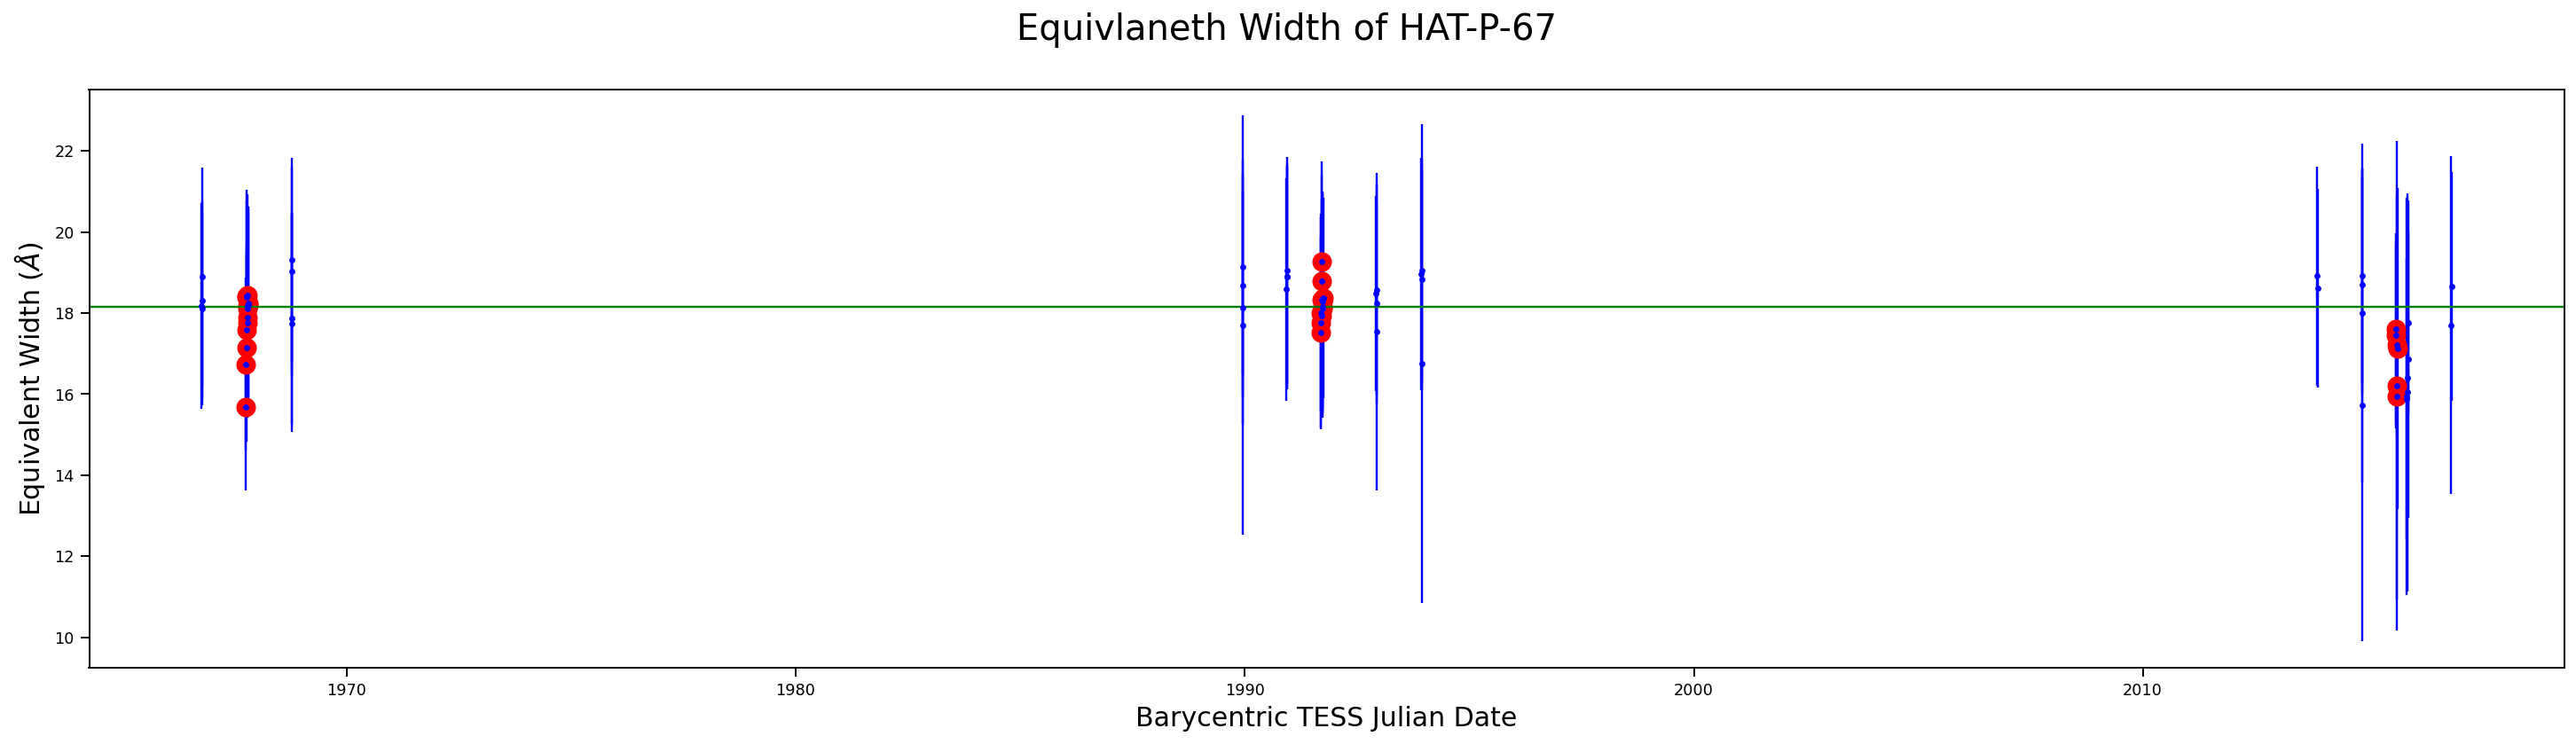

In [13]:
plt.figure(figsize=(25,6))
plt.errorbar(df.btjd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.btjd[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
#plt.ylim(0.9,1.32)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Barycentric TESS Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
plt.savefig(f'../figures/{target_name}.jpg')

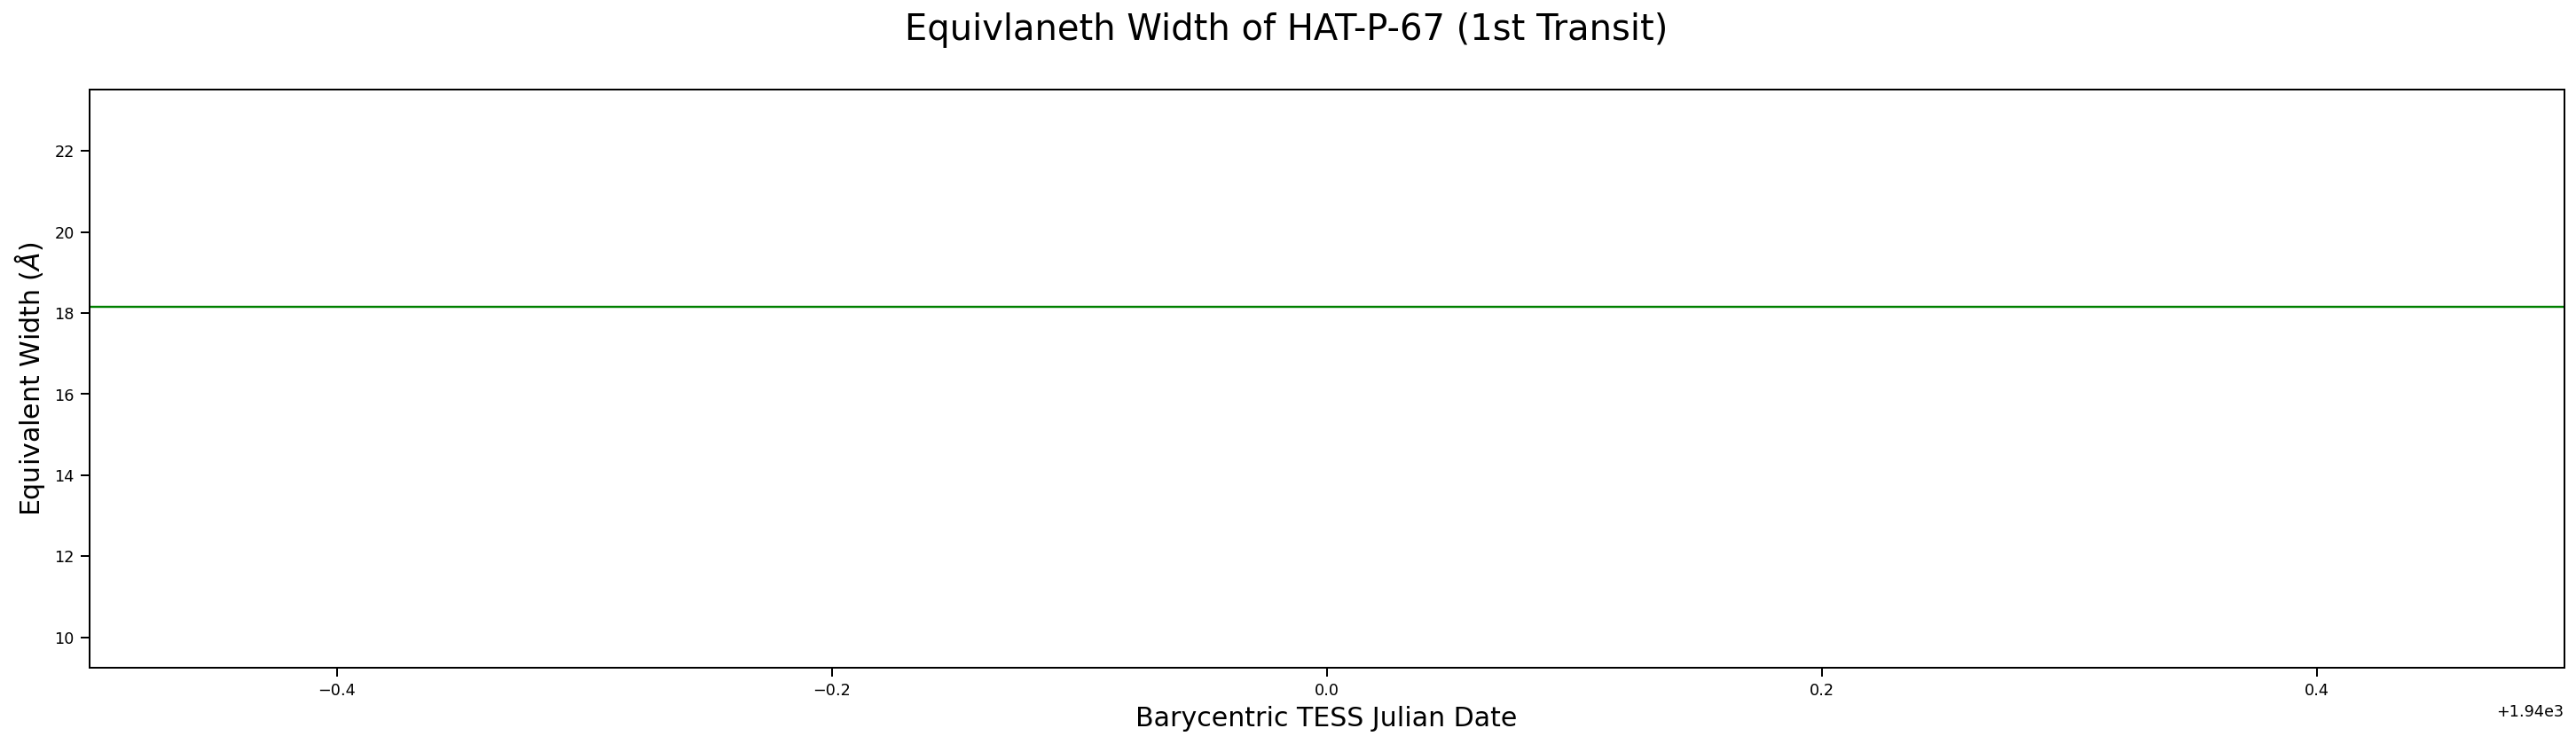

In [14]:
#1st in transit plot
plt.figure(figsize=(25,6))
plt.errorbar(df.btjd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.btjd[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
#plt.ylim(1.05,1.25)
plt.xlim(1939.5,1940.5)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name} (1st Transit)', fontsize=20)
plt.xlabel('Barycentric TESS Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15) 
plt.savefig(f'../figures/IN_TRANSIT_1_{target_name}.jpg')

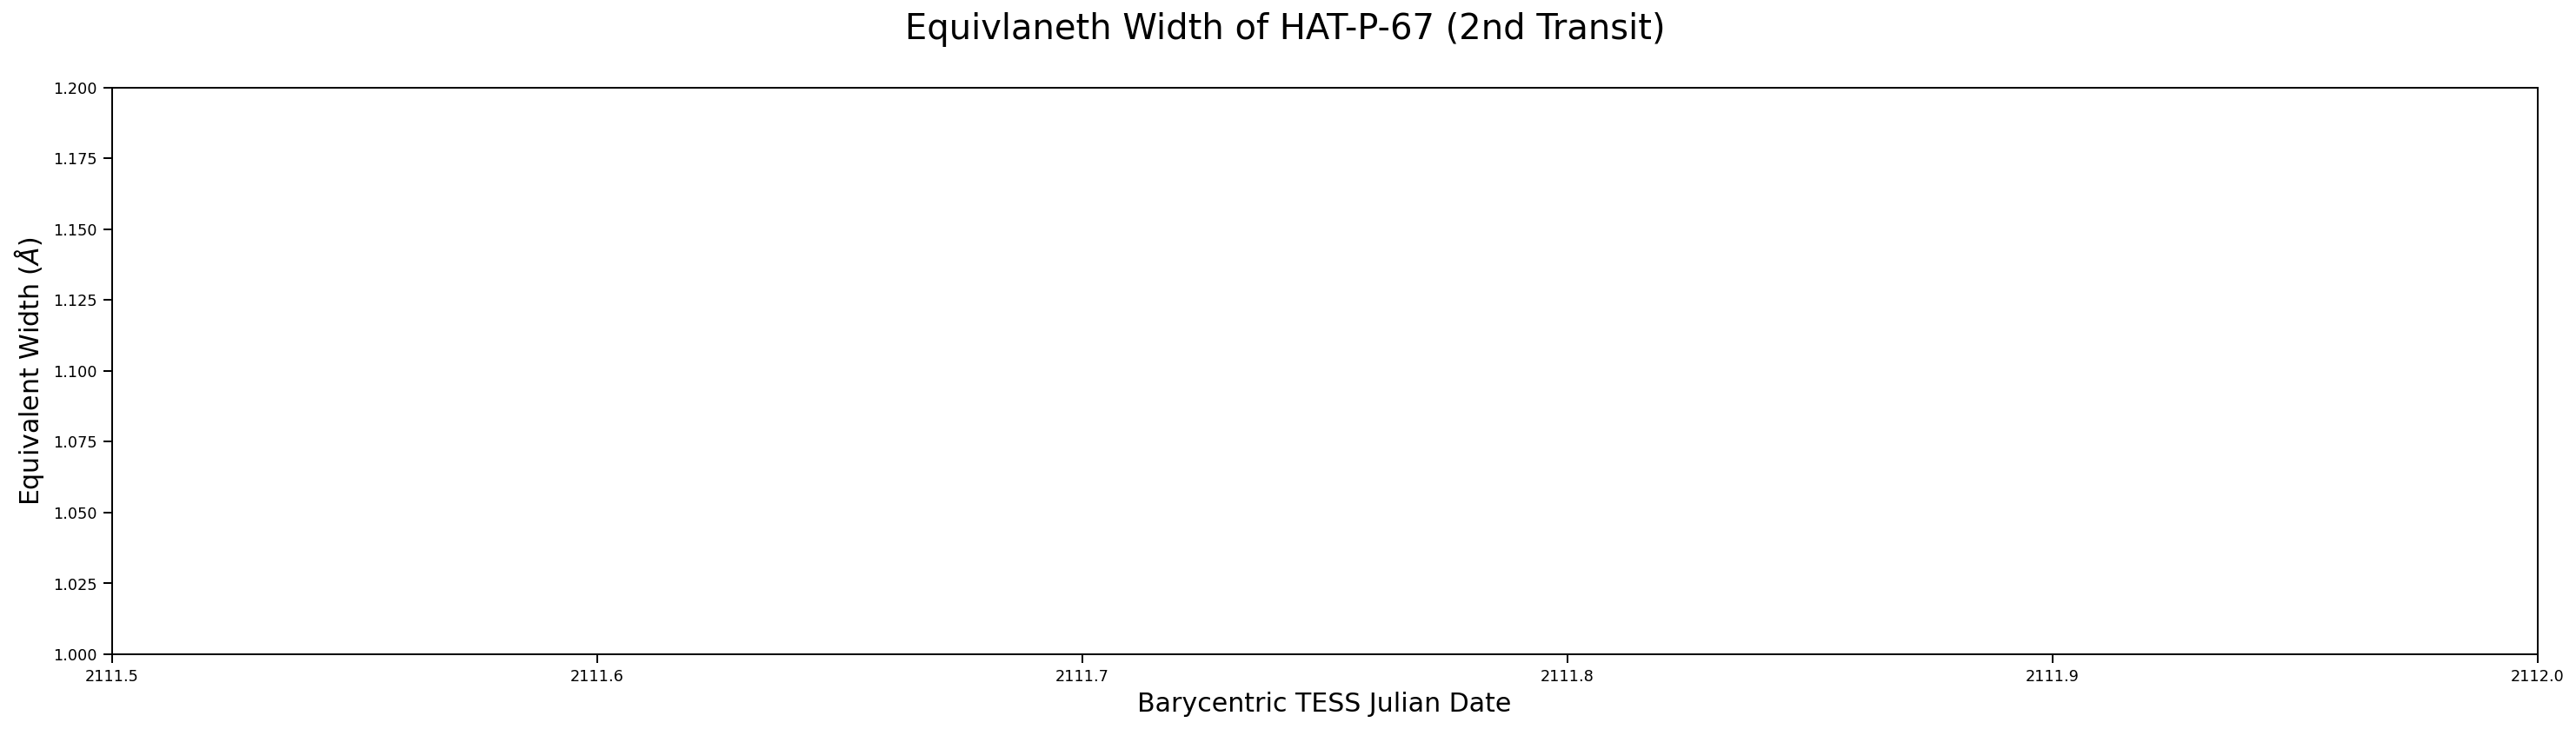

In [15]:
#2nd in transit plot
plt.figure(figsize=(25,6))
plt.errorbar(df.btjd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.btjd[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
plt.ylim(1.0,1.2)
plt.xlim(2111.5,2112)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name} (2nd Transit)', fontsize=20)
plt.xlabel('Barycentric TESS Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15) 
plt.savefig(f'../figures/IN_TRANSIT_2_{target_name}.jpg')

In [16]:
df['phase']=np.mod(df.btjd-t_c_btjd,orbital_period) #transit midpoint always at 0
df['normalized_phase']=df['phase']/orbital_period

In [17]:
df.describe() #max less than orbital period, normalized less than 1

,ew,ew_unc,gaussian_width,gaussian_width_unc,int_wv,jd,obs_line_center,obs_line_center_unc,qidx,btjd,phase,normalized_phase
count,70.000000,70.000000,70.000000,70.000000,70.0,7.000000e+01,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,17.950864,2.928189,8.092100,1.520234,8542.0,2.458991e+06,8533.887741,1.532518,6644.514286,1991.387697,2.524513,0.524836
std,0.926916,0.952117,0.484303,0.293909,0.0,1.841934e+01,0.536123,0.385372,199.176402,18.419340,1.909583,0.396994
min,15.685394,1.989017,6.840736,1.163876,8542.0,2.458967e+06,8532.998950,1.145241,6436.000000,1966.770274,0.058575,0.012178
25%,17.595024,2.433443,7.894607,1.343642,8542.0,2.458969e+06,8533.554490,1.325088,6438.000000,1968.774835,0.107579,0.022365
50%,18.162295,2.619045,8.241679,1.440111,8542.0,2.458992e+06,8533.745937,1.418849,6588.000000,1991.716920,2.955340,0.614403
75%,18.600356,2.771121,8.388523,1.534676,8542.0,2.459015e+06,8534.157657,1.512679,6938.000000,2014.633812,4.647562,0.966209
max,19.313069,6.038864,8.867717,2.786327,8542.0,2.459017e+06,8535.391939,3.427078,6943.000000,2016.873009,4.807390,0.999436


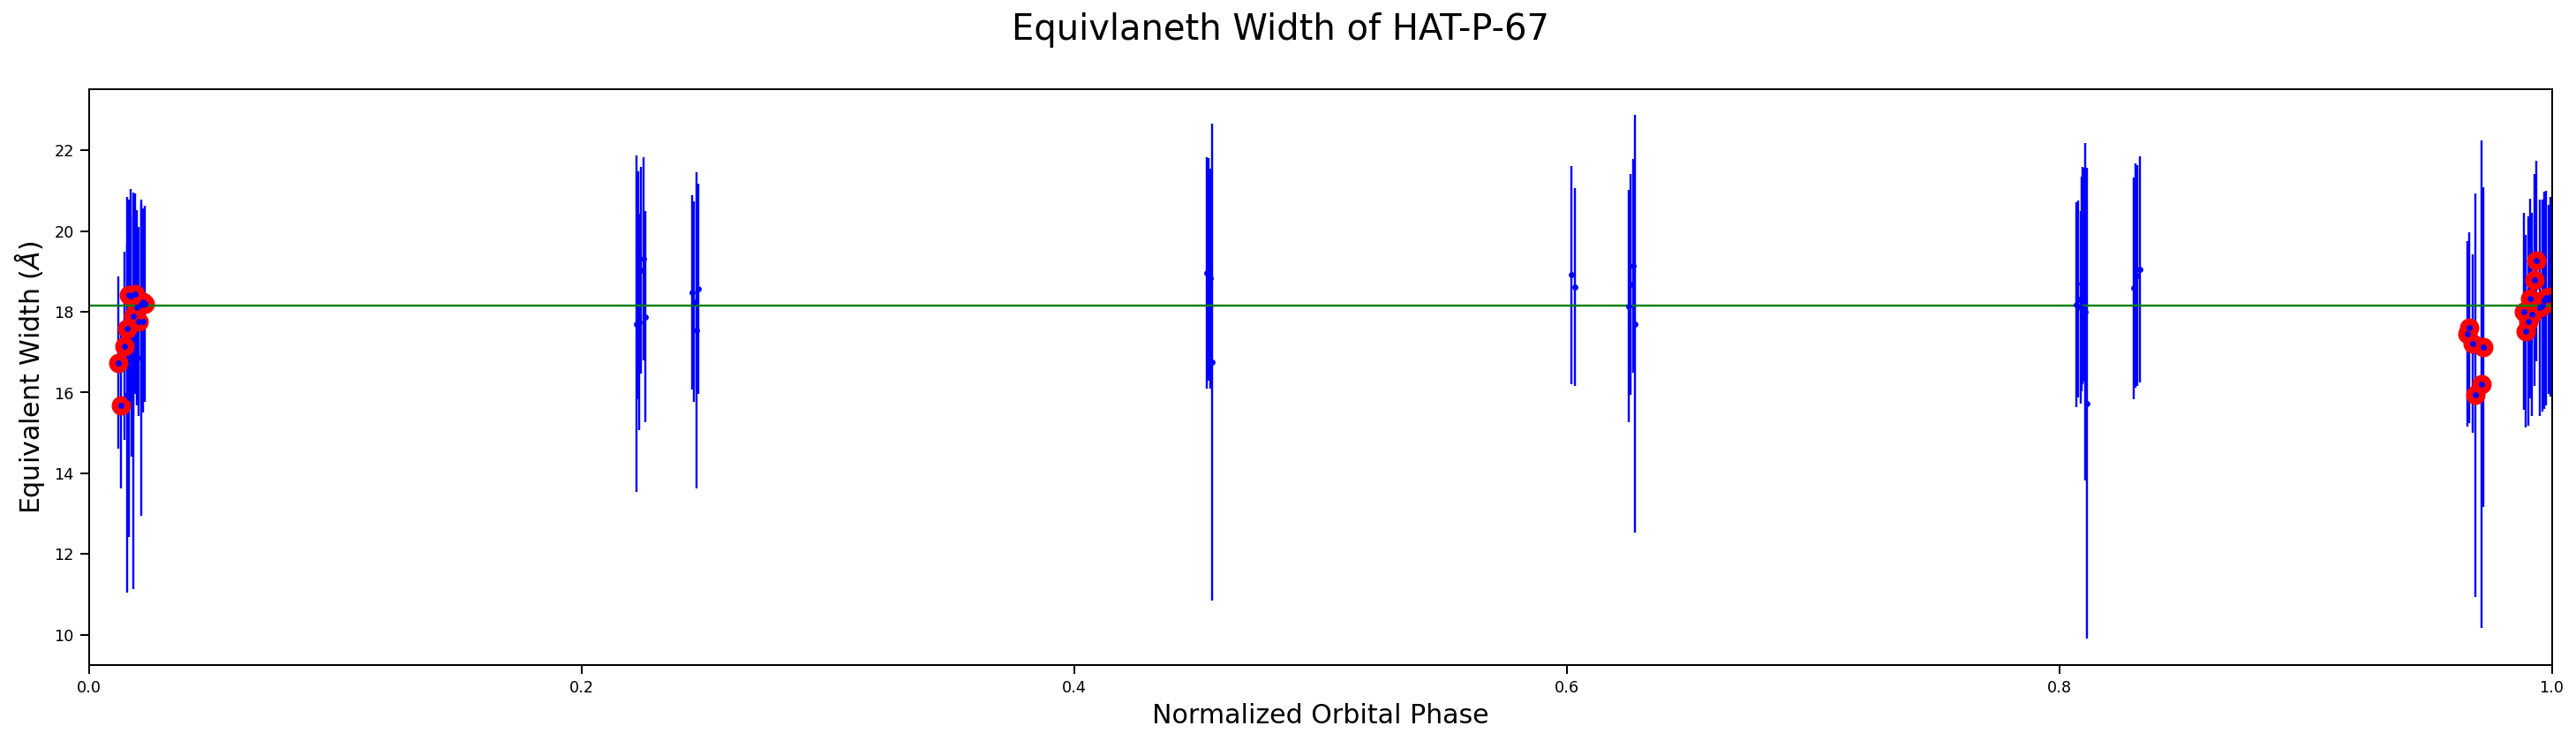

In [18]:
plt.figure(figsize=(25,6))
plt.errorbar(df.normalized_phase, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.normalized_phase[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
#plt.ylim(0.9,1.32)
plt.xlim(0,1)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Normalized Orbital Phase', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
plt.savefig(f'../figures/{target_name}.jpg')

Let's define a variable called 'shifted' in two steps.

In [22]:
second_half_mask = df.normalized_phase > 0.5
first_half_mask = ~second_half_mask

In [29]:
df['shifted']=df.normalized_phase
df.shifted[second_half_mask]=df.shifted[second_half_mask]-1
df.shifted[second_half_mask]

172   -0.011235
173   -0.010414
174   -0.009593
175   -0.008772
176   -0.007951
177   -0.007131
178   -0.006310
180   -0.004668
181   -0.003847
182   -0.003026
183   -0.002206
184   -0.001385
185   -0.000564
186   -0.034407
187   -0.033586
189   -0.031945
190   -0.031124
193   -0.028661
194   -0.027840
195   -0.193023
196   -0.192177
197   -0.191329
198   -0.190482
203   -0.374702
204   -0.373881
205   -0.373060
206   -0.372240
207   -0.169755
208   -0.168934
209   -0.168113
210   -0.167292
219   -0.398134
221   -0.396493
222   -0.191029
223   -0.190208
224   -0.189388
225   -0.188567
Name: shifted, dtype: float64

In [ ]:
plt.figure(figsize=(25,6))
plt.errorbar(df.shifted, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.shifted[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
#plt.ylim(0.9,1.32)
plt.xlim(0,1)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Normalized Orbital Phase', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
plt.savefig(f'../figures/{target_name}.jpg')